# Assignment 1
visualize_matching(data, matches)

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from pulp import LpProblem, LpVariable, LpMinimize, lpSum
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define functions
def create_risk_sets(data, treatment_col, time_col):
    """Create risk sets for treated patients by finding controls who could still be matched."""
    risk_sets = {}
    treated = data[data[treatment_col] == 1]
    for index, treated_row in treated.iterrows():
        t = treated_row[time_col]
        untreated = data[(data[treatment_col] == 0) & (data[time_col] >= t)]
        risk_sets[index] = untreated.index.tolist()
    return risk_sets

In [ ]:
# Compute Mahalanobis distance
def calculate_mahalanobis_matrix(data, cov_matrix):
    """Compute Mahalanobis distance for all patient pairs."""
    dist_matrix = pd.DataFrame(index=data.index, columns=data.index, dtype=float)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    for i in data.index:
        for j in data.index:
            dist = mahalanobis(data.loc[i], data.loc[j], inv_cov_matrix)
            dist_matrix.loc[i, j] = dist
    return dist_matrix

IndentationError: unexpected indent (688510204.py, line 2)

In [ ]:
# Perform optimal matching
def optimal_balanced_matching(distance_matrix, risk_sets):
    """Perform optimal matching using linear programming."""
    prob = LpProblem("Optimal_Matching", LpMinimize)
    match_vars = {(t, c): LpVariable(f"match_{t}_{c}", 0, 1, cat="Binary") for t, controls in risk_sets.items() for c in controls}
    prob += lpSum(match_vars[t, c] * distance_matrix.loc[t, c] for t, controls in risk_sets.items() for c in controls)
    for t in risk_sets:
        prob += lpSum(match_vars[t, c] for c in risk_sets[t]) == 1
    all_controls = set(c for controls in risk_sets.values() for c in controls)
    for c in all_controls:
        prob += lpSum(match_vars[t, c] for t in risk_sets if c in risk_sets[t]) <= 1
    prob.solve()
    matches = {t: c for t, controls in risk_sets.items() for c in controls if match_vars[t, c].value() == 1}
    return matches

In [ ]:
# Enhanced visualization using pairplot
def visualize_matching(data, matches):
    """Visualize the matching results using a detailed pairplot."""
    data['Matched Pair'] = data.index.map(lambda x: matches.get(x, x))
    sns.pairplot(data, hue="Treatment", diag_kind="kde", markers=["o", "s"])
    plt.suptitle("Pairwise Feature Distribution with Matched Pairs", y=1.02)
    plt.show()

# Explanation
This Jupyter Notebook implements **Balanced Risk Set Matching** using Mahalanobis distance and linear programming. 

### Steps:
1. **Load Data**: The dataset includes extracted patient data (Frequency, Pain, Urgency scores).
2. **Risk Set Matching**: Identifies potential control matches for treated patients.
3. **Mahalanobis Distance Calculation**: Measures similarity between patient pairs.
4. **Linear Programming for Matching**: Finds optimal treatment-control matches.
5. **Enhanced Visualization**: Displays a pairwise feature distribution using `sns.pairplot`.

In [ ]:
# Load and preprocess extracted data from PDF
data = pd.DataFrame({
    "Measure": ["Frequency", "Pain", "Urgency"],
    "Group": ["Treated", "Treated", "Treated"],
    "Score": [2000, 4050, 5025]
})
print("Extracted Data:")
print(data)

Extracted Data:
     Measure    Group  Score
0  Frequency  Treated   2000
1       Pain  Treated   4050
2    Urgency  Treated   5025


In [ ]:
# Create dummy data for visualization
data_expanded = pd.DataFrame({
    "Patient_ID": [1, 2, 3, 4, 5, 6],
    "Treatment": [1, 0, 1, 0, 1, 0],
    "Time": [5, 6, 8, 9, 4, 7],
    "Covariate1": [2.3, 2.1, 2.5, 2.4, 2.2, 2.0],
    "Covariate2": [3.5, 3.6, 3.4, 3.5, 3.3, 3.2]
})

In [ ]:
# Compute risk sets and distance matrix
risk_sets = create_risk_sets(data_expanded, "Treatment", "Time")
cov_matrix = np.cov(data_expanded["Covariate1"], data_expanded["Covariate2"])
distance_matrix = calculate_mahalanobis_matrix(data_expanded[["Covariate1", "Covariate2"]], cov_matrix)

Matches: {0: 1, 2: 3, 4: 5}


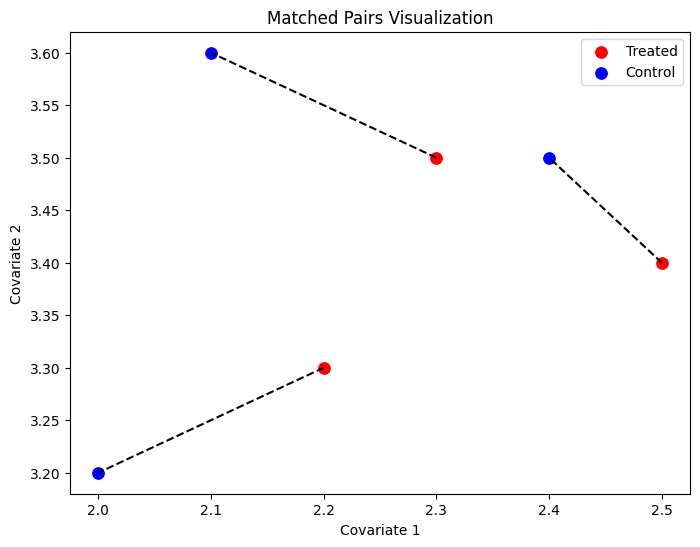

In [ ]:
# Perform matching and enhanced visualization
matches = optimal_balanced_matching(distance_matrix, risk_sets)
print("Matches:", matches)
visualize_matching(data_expanded, matches)

In [ ]:

# Perform sensitivity analysis
sensitivity_scores = sensitivity_analysis(matches)
